In [144]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.backend import square, mean
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import time

PLOT=True
# PLOT=False

SEQ_LEN=60
OUTPUT_LEN=180
EPOCHS=9
STEPS_PER_EPOCH=100
BATCH_SIZE=256
TARGET_VALUE="Close"
sequence_length = 60
shift_steps=30
warmup_steps = 50

In [145]:
%matplotlib inline

In [146]:
url = "./datasets/eurusd-m15-2018/EURUSD.csv"
df = pd.read_csv(url)
df.drop("Volume", 1, inplace=True)
df.drop("Date", 1, inplace=True)
df.drop("Timestamp", 1, inplace=True)
# df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
# df.set_index('date', inplace=True)

df.head()

,Open,High,Low,Close
0,1.11521,1.11562,1.11378,1.11380
1,1.11380,1.11447,1.11354,1.11422
2,1.11426,1.11491,1.11413,1.11482
3,1.11483,1.11485,1.11422,1.11430
4,1.11438,1.11489,1.11397,1.11425


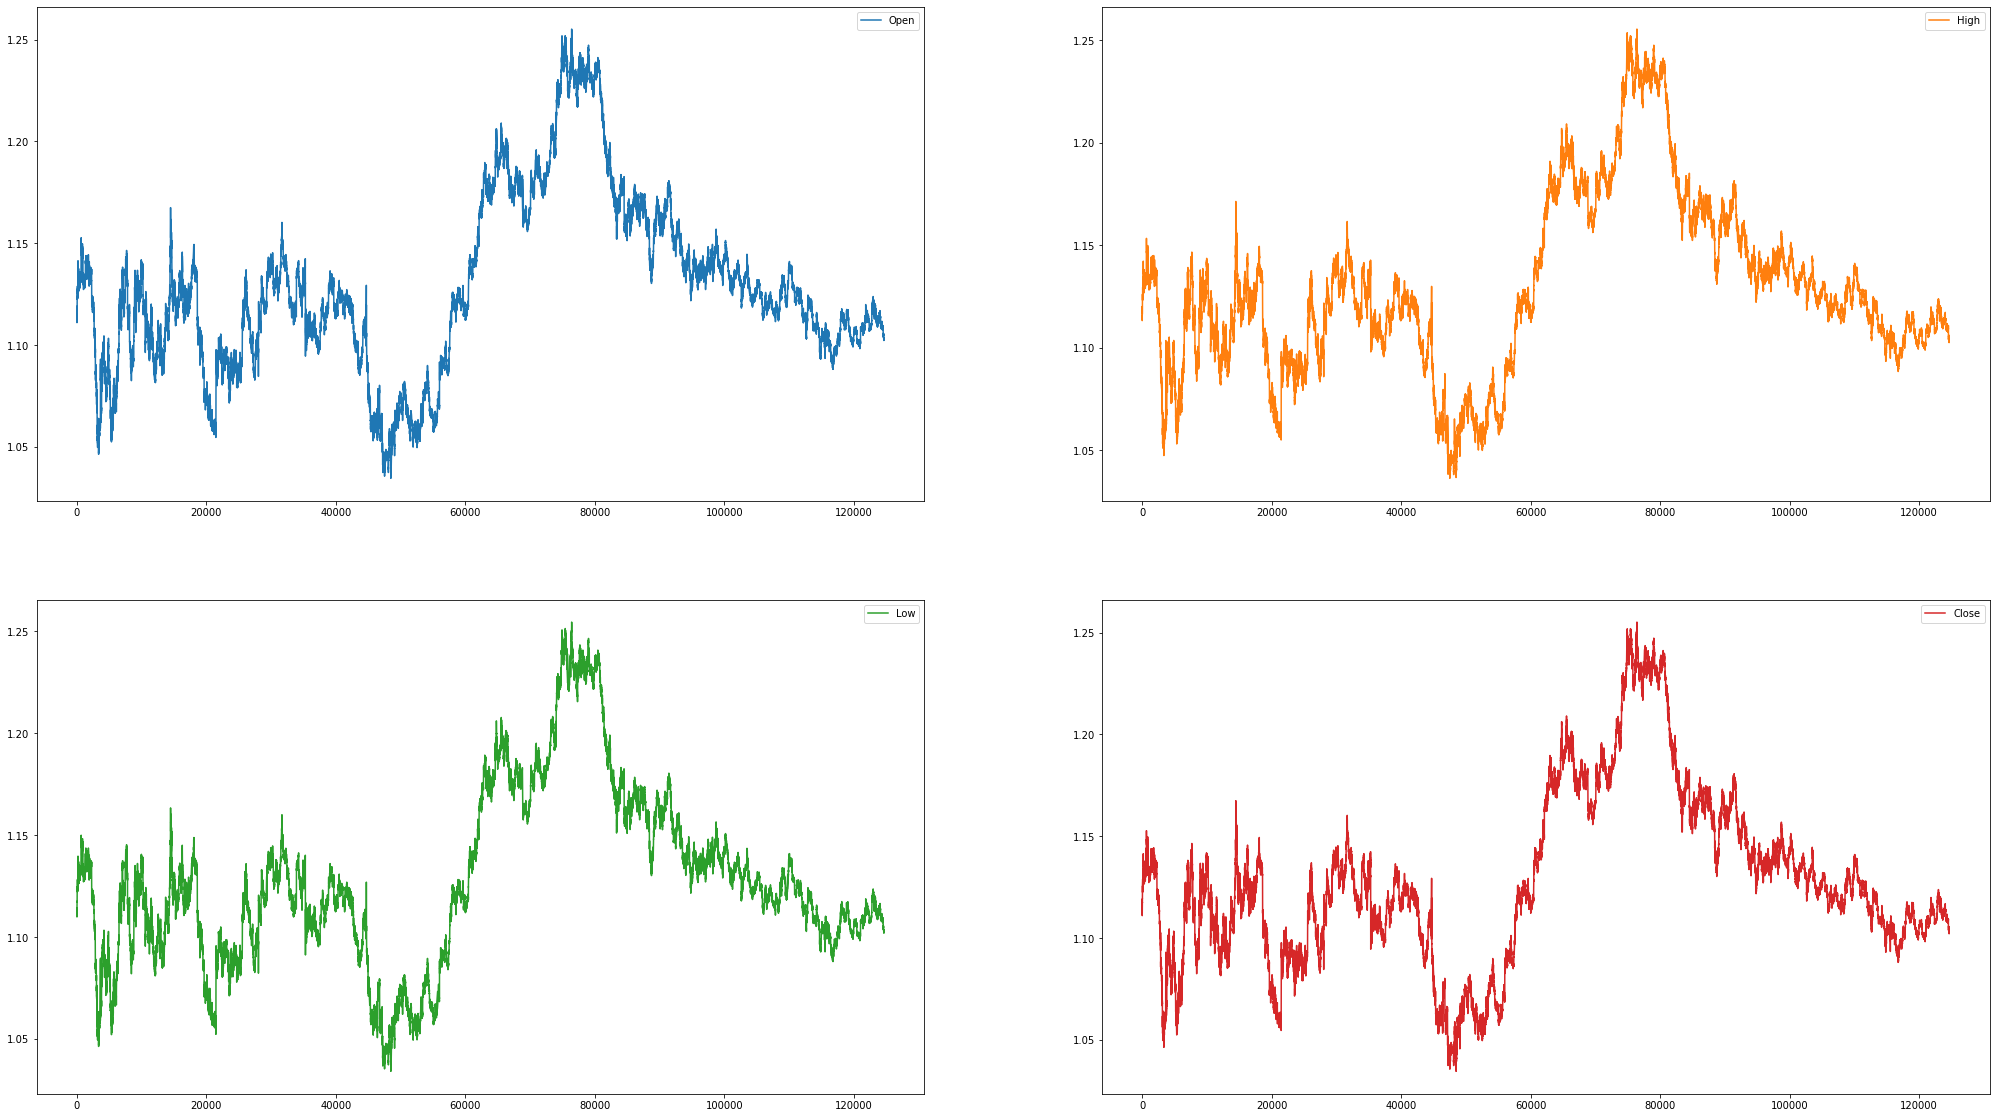

In [147]:
if PLOT:
    df.plot(subplots=True, layout=(2, 2), figsize=(35, 20), sharex=False)

In [148]:
df[TARGET_VALUE]

0         1.11380
1         1.11422
2         1.11482
3         1.11430
4         1.11425
           ...   
124639    1.10277
124640    1.10286
124641    1.10274
124642    1.10250
124643    1.10224
Name: Close, Length: 124644, dtype: float64

In [149]:

df_targets=df[TARGET_VALUE].shift(-shift_steps) # yeah, that minus there is realllyyyy important
print(df_targets)

0         1.11834
1         1.11855
2         1.11943
3         1.11939
4         1.12091
           ...   
124639        NaN
124640        NaN
124641        NaN
124642        NaN
124643        NaN
Name: Close, Length: 124644, dtype: float64


In [150]:
# linewidth=0.5
# ax=df_targets.plot(figsize=(30,15), linewidth=linewidth)
# df[TARGET_VALUE].plot(ax=ax, linewidth=linewidth)

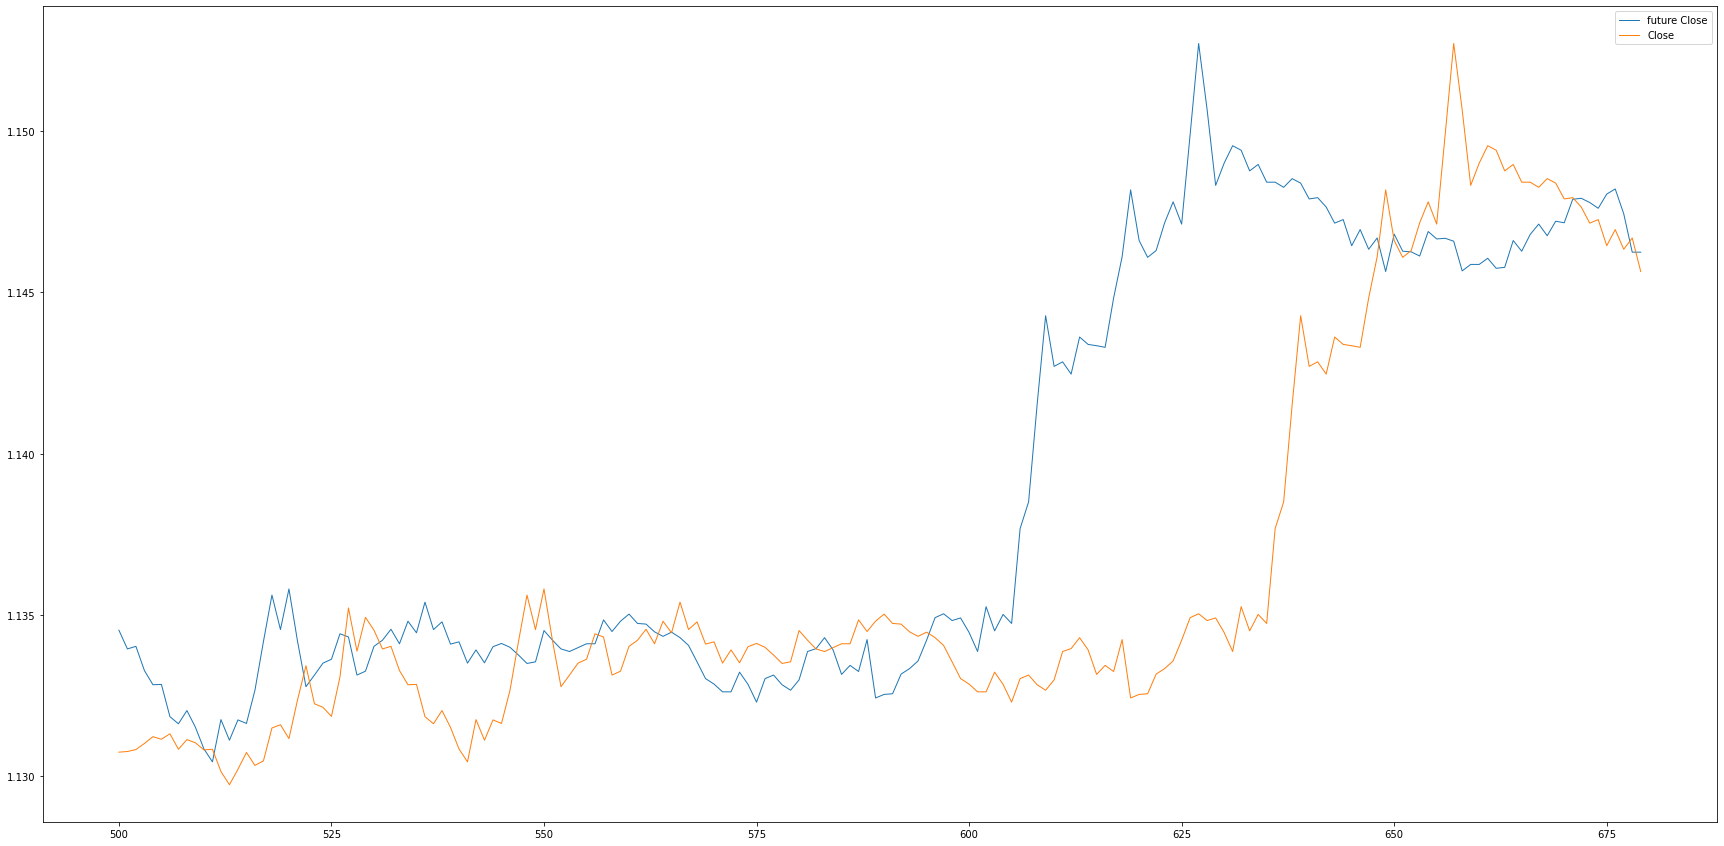

In [151]:
offset=500
linewidth=1
ax=df_targets[offset:offset+3*SEQ_LEN].plot(figsize=(30,15), linewidth=linewidth)
df[TARGET_VALUE][offset:offset+3*SEQ_LEN].plot(ax=ax, linewidth=linewidth)
ax.legend(["future "+TARGET_VALUE, TARGET_VALUE])

In [152]:
df_targets.tail(OUTPUT_LEN+3)

124461    1.10892
124462    1.10860
124463    1.10857
124464    1.10867
124465    1.10837
           ...   
124639        NaN
124640        NaN
124641        NaN
124642        NaN
124643        NaN
Name: Close, Length: 183, dtype: float64

In [153]:
x_data=df[TARGET_VALUE].values[0:-shift_steps]
print(type(x_data))
print("shape:", x_data.shape)

<class 'numpy.ndarray'>
shape: (124614,)


In [154]:
y_data=df_targets.values[0:-shift_steps]
print(type(y_data))
print("shape:", y_data.shape)

<class 'numpy.ndarray'>
shape: (124614,)


In [155]:
train_split = 0.9

In [156]:
num_data = len(x_data)

In [157]:
num_train = int(train_split * num_data)
num_train

112152

In [158]:
num_test = num_data - num_train
num_test

12462

In [159]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

124614

In [160]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

124614

In [161]:
num_x_signals = x_data.shape[1] if len(x_data.shape)>1 else 1
num_x_signals

1

In [162]:
num_y_signals = y_data.shape[1] if len(y_data.shape)>1 else 1
num_y_signals

1

In [163]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 1.03453
Max: 1.2551700000000001


In [164]:
x_scaler = MinMaxScaler()
x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped)

In [165]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [166]:
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped)

In [167]:
y_scaler = MinMaxScaler()
y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [168]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(112152, 1)
(112152, 1)


In [169]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, shift_steps, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        # print(y_shape)
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length - shift_steps-1000)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx+sequence_length:idx+sequence_length+shift_steps]
        
        yield (x_batch, y_batch)

In [170]:
sequence_length

60

In [171]:
generator = batch_generator(batch_size=BATCH_SIZE,
                            sequence_length=sequence_length)

In [172]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 60, 1)
(256, 30, 1)
(256, 60, 1)
(256, 30, 1)


In [173]:
# print(x_batch[0])

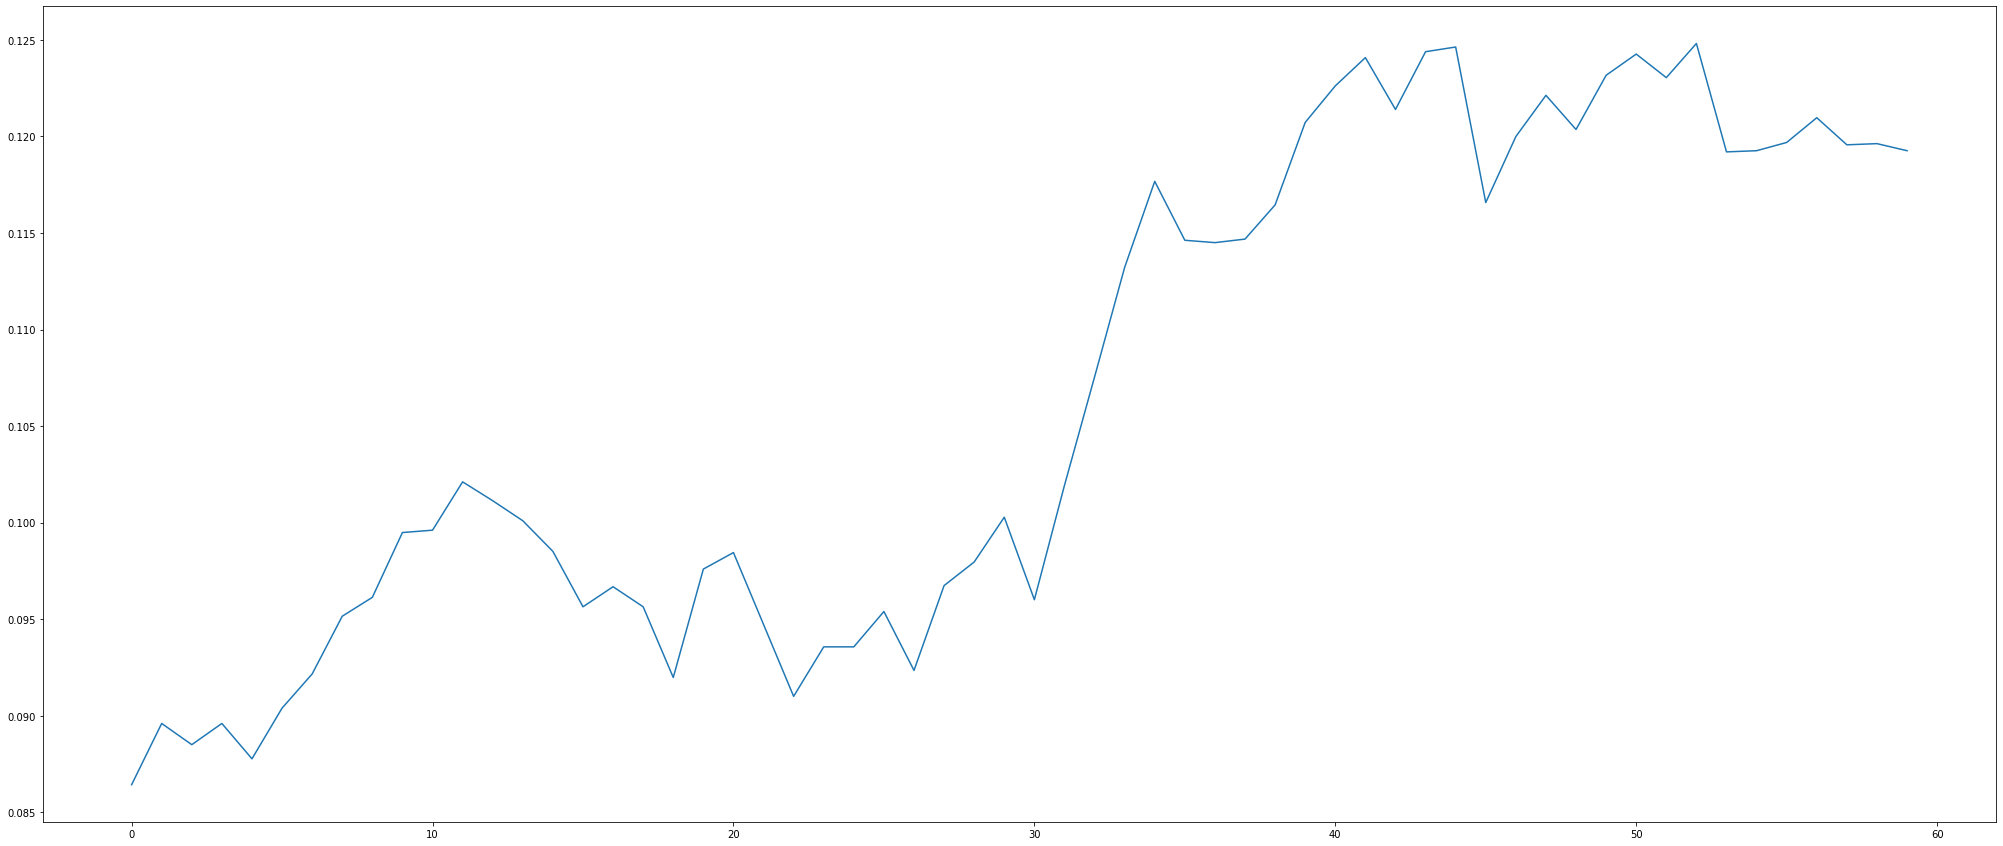

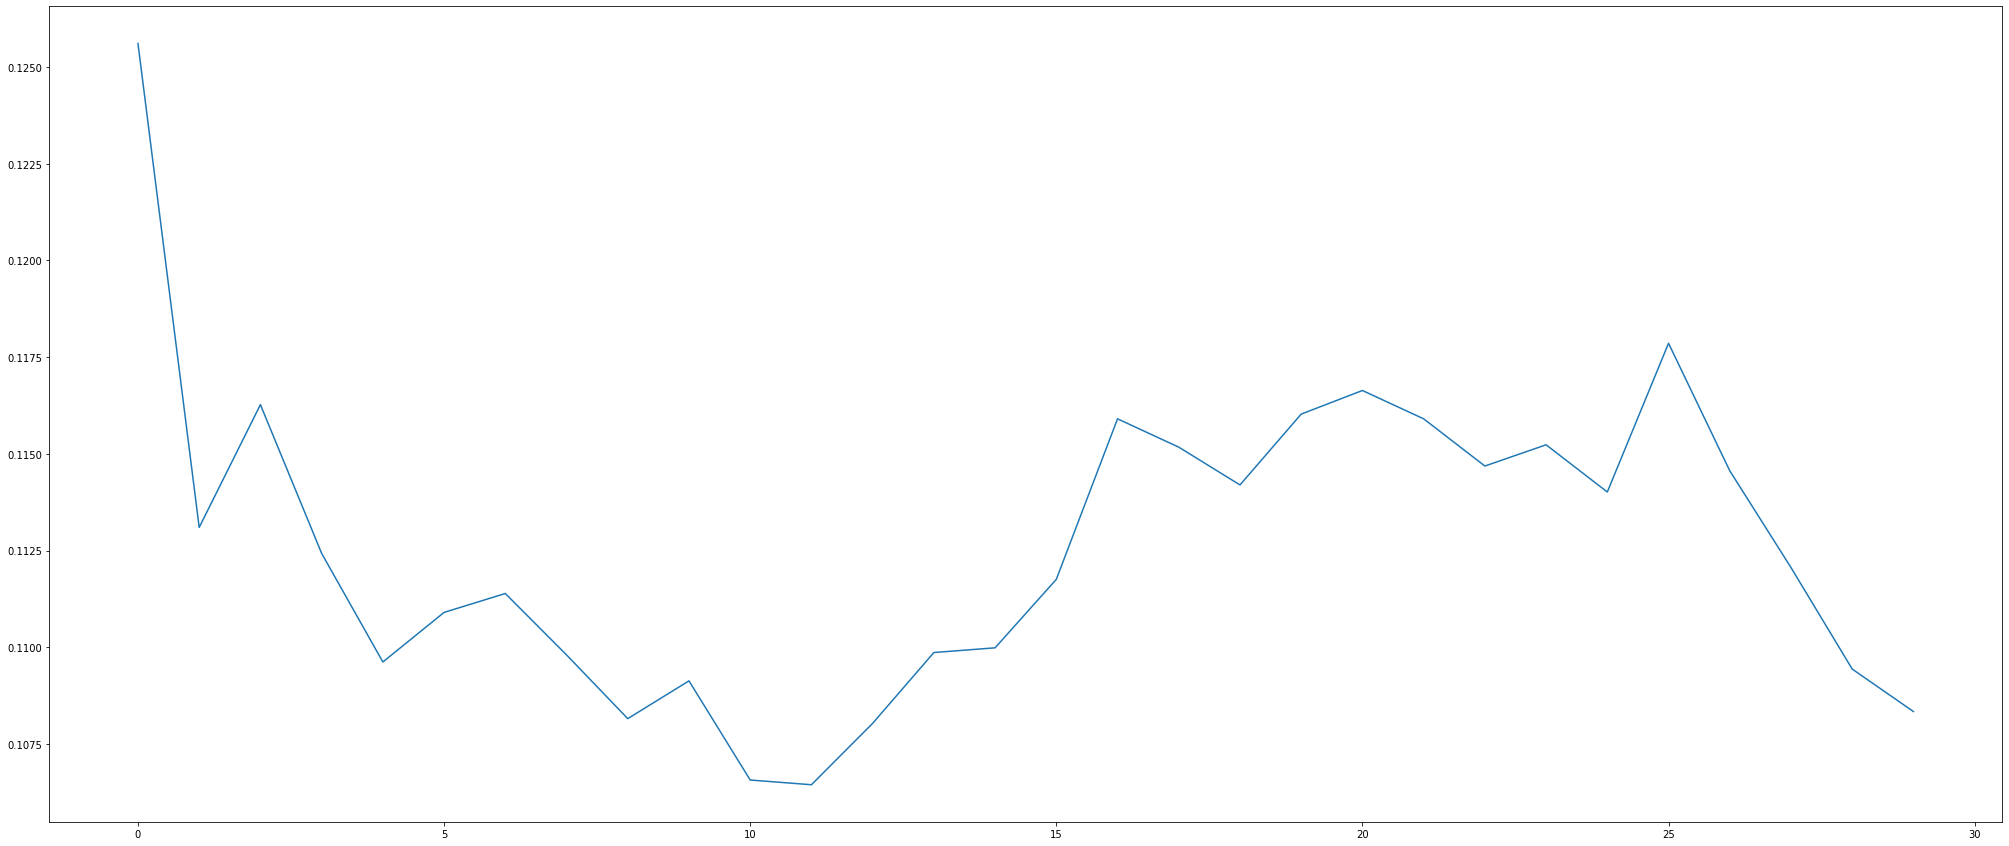

In [174]:
batch = 0  
signal = 0
seqx = x_batch[batch, :, signal]
_, axes = plt.subplots(figsize=(35,15))
axes.plot(seqx)

seqy = y_batch[batch, :, signal]
_, axes = plt.subplots(figsize=(35,15))
axes.plot(seqy)
# pd.DataFrame(data={"seqx":seqx, "seqy":seqy}).plot(figsize=(30,15))

In [175]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [222]:
model = Sequential()
model.add(GRU(units=512,
            #   return_sequences=True,
              input_shape=(None, num_x_signals,)))
# model.add(Dense(num_y_signals, activation='sigmoid'))


init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(shift_steps, activation='linear', kernel_initializer=init))

In [223]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]
    # print(y_true, y_pred)
    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [224]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss="mae", optimizer=optimizer)

In [225]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 512)               791040    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                15390     
Total params: 806,430
Trainable params: 806,430
Non-trainable params: 0
_________________________________________________________________


In [226]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)                           
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.5,
                                       min_lr=1e-6,
                                       patience=3,
                                       verbose=1) 
callbacks = [callback_early_stopping,
             callback_reduce_lr]                                                                   

In [227]:
%%time
model.fit(x=generator,
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/9
100/100 [==============================] - ETA: 0s - loss: 0.1261

ValueError: in user code:

    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:912 test_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1230 mean_absolute_error
        return K.mean(math_ops.abs(y_pred - y_true), axis=-1)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10103 sub
        "Sub", x=x, y=y, name=name)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 30 and 12462 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](sequential_4/dense_4/BiasAdd, mean_absolute_error/remove_squeezable_dimensions/Squeeze)' with input shapes: [?,30], [?,12462].


In [202]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 996us/step - loss: 0.0013


In [203]:
print("loss (test-set):", result)

loss (test-set): 0.0012890095822513103


In [220]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    x_orig=x_scaler.inverse_transform(x)

    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    print(x)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled.reshape(1,-1)[0]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true.reshape(1,-1)[0]
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(30,15))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    plt.plot(x_orig, label='x')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(TARGET_VALUE)
    plt.legend()
    plt.show()

In [221]:
plot_comparison(start_idx=100000, length=1000, train=True)

[[[0.49424402]
  [0.49288434]
  [0.49107143]
  [0.49043691]
  [0.48916788]
  [0.48785352]
  [0.48749094]
  [0.48690174]
  [0.48980239]
  [0.48966642]
  [0.49152466]
  [0.48468093]
  [0.48957578]
  [0.4876269 ]
  [0.48980239]
  [0.48504351]
  [0.48513416]
  [0.48758158]
  [0.48998368]
  [0.49084482]
  [0.48903191]
  [0.48998368]
  [0.48966642]
  [0.48835207]
  [0.49057288]
  [0.49039159]
  [0.4902103 ]
  [0.48971175]
  [0.48871465]
  [0.49138869]
  [0.49129804]
  [0.49156998]
  [0.49079949]
  [0.49315627]
  [0.49265772]
  [0.4932016 ]
  [0.49292966]
  [0.49406273]
  [0.49333756]
  [0.49184191]
  [0.49193256]
  [0.49274837]
  [0.49270305]
  [0.49365482]
  [0.4936095 ]
  [0.49333756]
  [0.49356418]
  [0.49379079]
  [0.49379079]
  [0.49338289]
  [0.49311095]
  [0.49510515]
  [0.49374547]
  [0.49279369]
  [0.49252175]
  [0.49524112]
  [0.49573967]
  [0.49632886]
  [0.49537708]
  [0.49551305]
  [0.4960116 ]
  [0.49533176]
  [0.49492386]
  [0.49510515]
  [0.49469724]
  [0.49637418]
  [0.49646

ValueError: Expected 2D array, got 1D array instead:
array=[0.44764185].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
plot_comparison(start_idx=200000, length=1000, train=True)

In [ ]:
plot_comparison(start_idx=200, length=1000, train=False)

In [ ]:
plot_comparison(start_idx=2000, length=1000, train=False)

In [ ]:
pred=model.predict(x_batch)

In [ ]:
predzz=pred[0].reshape(1,-1)[0]
pd.DataFrame(data=predzz[30:]).plot()

In [ ]:
xzz=x_batch[0].reshape(1,-1)[0]
pd.DataFrame(data=xzz).plot()

In [ ]:
offset= 60
d = {"y": predzz, "x": xzz}
pd.DataFrame(data=d).plot(figsize=(30,15))

In [ ]:
print(predzz.shape)
print(xzz.shape)

In [ ]:
batch=3
seqx = x_batch[batch, :, signal]
# _, axes = plt.subplots(figsize=(35,15))
# axes.plot(seq)

seqy = y_batch[batch, :, signal]

np.array([seqx.reshape(-1,1)])
xs=model.predict(np.array([seqx.reshape(-1,1)]))

In [ ]:
xs[0].reshape(1,-1)[0][:10]

In [ ]:
seqx

In [ ]:
pd.DataFrame(data={"x": seqx[20:], "y": xs[0].reshape(1,-1)[0][20:]}).plot()